# **Regression with Widgets**
***
***

### Import the necessary packages for creating data magic!

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import dash
import sys
import plotly.graph_objs as go
from scipy.stats import linregress
from ipywidgets import widgets
from IPython.display import display, clear_output


## **The CentralityAnalysis() class contains six methods:**

**generate_graph():** This method creates a graph object using the Networkx nx.from_pandas_edgelist().
    
**generate_eigenVals():** This method creates a list of network nodes with corresponding node eigenvector centrality values using nx.eigenvector_centrality_numpy().
    
**generate_closeVals():** This method creates a list of network nodes with corresponding node closeness centrality values using nx.closeness_centrality().
    
**generate_degrVals():** This method creates a list of network nodes with corresponding node degree centrality values using nx.degree_centrality().
    
**generate_betwVals():** This method creates a list of network nodes with corresponding node betweenness centrality values using nx.betweenness_centrality().
    
**generate_edgeBetw():** This method creates a list of network edges with corresponding edge betweenness centrality values using nx.edge_betweenness_centrality().

In [ ]:
class CentralityAnalysis:
    def __init__(self):
        super().__init__()
        # Initialize graph variable
        self.G = None
        
    def generate_graph(self):
        # Read data and create graph
        df = pd.read_csv('1YOK.cif_ringEdges', sep='\t')
        subset_df = df.loc[(df['NodeId1'].str.contains('A:')) & (df['NodeId2'].str.contains('A:'))]
        self.G = nx.from_pandas_edgelist(subset_df, 'NodeId1', 'NodeId2', create_using=nx.Graph())
        
    def generate_eigenVals(self):
        # Check if graph is generated
        if self.G is None:
            raise ValueError("Graph not generated. Call generate_graph() first.")
        
        eigen_centr = nx.eigenvector_centrality_numpy(self.G)
        eigendf = pd.DataFrame(list(eigen_centr.items()), columns=['node', 'value'])
        eigendf['norm_val'] = eigendf['value'] / eigendf['value'].max()
        return eigendf
        
    def generate_closeVals(self):
        if self.G is None:
            raise ValueError("Graph not generated. Call generate_graph() first.")
        
        close_centr = nx.closeness_centrality(self.G)
        closedf = pd.DataFrame(list(close_centr.items()), columns=['node', 'value'])
        closedf['norm_val'] = closedf['value'] / closedf['value'].max()
        return closedf
        
    def generate_degrVals(self):
        if self.G is None:
            raise ValueError("Graph not generated. Call generate_graph() first.")
        
        degr_centr = nx.degree_centrality(self.G)
        degrdf = pd.DataFrame(list(degr_centr.items()), columns=['node', 'value'])
        degrdf['norm_val'] = degrdf['value'] / degrdf['value'].max()
        return degrdf
        
    def generate_betwVals(self):
        if self.G is None:
            raise ValueError("Graph not generated. Call generate_graph() first.")
        
        betw_centr = nx.betweenness_centrality(self.G)
        betwdf = pd.DataFrame(list(betw_centr.items()), columns=['node', 'value'])
        betwdf['norm_val'] = betwdf['value'] / betwdf['value'].max()
        return betwdf
            
    def generate_edgeBetw(self):
        if self.G is None:
            raise ValueError("Graph not generated. Call generate_graph() first.")
        
        edge_betw = nx.edge_betweenness_centrality(self.G)
        edge_betwdf = pd.DataFrame(list(edge_betw.items()), columns=['Pair', 'Edge Value'])
        edge_betwdf[['Node1', 'Node2']] = pd.DataFrame(edge_betwdf['Pair'].tolist(), index=edge_betwdf.index)
        edge_betwdf = edge_betwdf[['Node1', 'Node2', 'Edge Value']]
        edge_betwdf['Norm Value'] = edge_betwdf['Edge Value'] / edge_betwdf['Edge Value'].max()
        return edge_betwdf

## **This is where the hardwork happens...**
###

In [ ]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

newGraph = CentralityAnalysis()
newGraph.generate_graph()

datasets = ['eigenVals', 'betwVals', 'degrVals', 'closeVals']
dataframes = {}

for dataset in datasets:
    df = getattr(newGraph, f'generate_{dataset}')()
    df['node'] = df['node'].str.replace(r'\D', '', regex=True)
    df['node'] = pd.to_numeric(df['node'])
    df = df.sort_values(by='node', ascending=True)
    df = df.drop(df.index[-1])
    dataframes[dataset] = df


# Define your dataframes (assuming dataframes is defined elsewhere)
norm_vals = {
    'Eigenvector centrality values': dataframes['eigenVals']['norm_val'],
    'Betweenness centrality values': dataframes['betwVals']['norm_val'],
    'Degree centrality values': dataframes['degrVals']['norm_val'],
    'Closeness centrality values': dataframes['closeVals']['norm_val']
}

# Create dropdown widgets for y-axis
y1_dropdown = widgets.Dropdown(
    options=[(key, key) for key in norm_vals.keys()], 
    value='Eigenvector centrality values', 
    description='X-axis:',
    style={'width': '300px', 'border-radius': '5px'}  # Adjust width and border-radius here
)
y2_dropdown = widgets.Dropdown(
    options=[(key, key) for key in norm_vals.keys()], 
    value='Betweenness centrality values', 
    description='Y-axis:',
    style={'width': '300px', 'border-radius': '5px'}  # Adjust width and border-radius here
)

# Create a button to plot data
plot_button = widgets.Button(
    description='Plot Data',
    style={'width': '200px', 'height': '40px', 'margin-top': '5px'}  # Adjust width, height, and margin-top here
)

# Create an output widget
out = widgets.Output()

# Define function to update the scatter plot
def update_plot(b):
    with out:
        clear_output(wait=True)
        y1_val = y1_dropdown.value
        y2_val = y2_dropdown.value
        y1_data = norm_vals[y1_val]
        y2_data = norm_vals[y2_val]

        # Calculate regression line
        slope, intercept, r_value, p_value, std_err = linregress(y1_data, y2_data)
        regression_line = slope * np.array(y1_data) + intercept

        # Format R and R-squared values
        r_text = f'R: {r_value:.2f}'
        r_squared_text = f'R-squared: {r_value**2:.2f}'

        # Add regression line with R and R-squared values to the legend
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=y1_data, y=y2_data, mode='markers', name='Scatter Plot'))
        fig.add_trace(go.Scatter(x=y1_data, y=regression_line, mode='lines', name=f'Regression Line ({r_text}, {r_squared_text})'))
        fig.update_layout(title='Scatterplot with Regression Analysis', xaxis_title=y1_val, yaxis_title=y2_val, width=800)  # Adjust width here
        fig.update_layout(template='ggplot2')  # Set plot style to ggplot2
        
        # Position the legend one-half inch below its current position and remove the legend box
        fig.update_layout(
            legend=dict(
                x=0,
                y=-0.5,  # Adjust the y-coordinate to move the legend down one-half inch
                traceorder="normal",
                font=dict(
                    family="sans-serif",
                    size=12,
                    color="black"
                ),
                bgcolor="rgba(0,0,0,0)",  # Set background color to transparent
                bordercolor="rgba(0,0,0,0)",  # Set border color to transparent
            )
        )
        
        fig.show()

# Register callback function with the button
plot_button.on_click(update_plot)

# Create a title widget
title = widgets.HTML('<h1 style="text-align: center;">Comparing Centrality Metrics with Regression Analysis</h1>')

# Display the dropdowns, button, and the output widget in a VBox
display(widgets.VBox([title, y1_dropdown, y2_dropdown, plot_button, out]))

# Initialize the plot
update_plot(None)


<br>
<font size='5'>This particular widget will take four data sets and by pairwise selection plot and replot the data along with the regression line and corresponding coefficients. This Jupyter Notebook can be downloaded along with the all the necessary files in order to order to create the image below. 
<br></br>
The app.py file is available for utilizing the plot as a dash web app. 
<br></br>
A requirements.txt file is also provided in case a Python environment is more your style!</font>

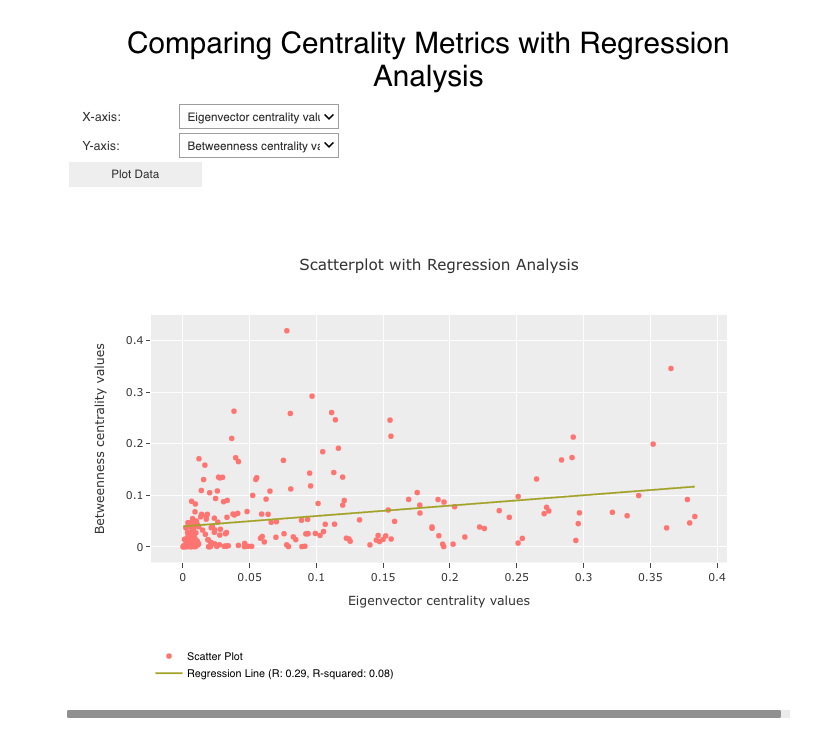